In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import corner
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as unit

seed = 1023123283

# Data Generation

In [2]:
with h5py.File("truth.h5",'r') as hf:
    m = np.array(hf['mtrue'])
    z = np.array(hf['ztrue'])
hf.close()

$$
m_{obs} \sim \mathcal{N}(m_{obs}|m,\sigma_m)
$$

In [3]:
Nobs = m.shape[0]
Nsamp = 4000

In [4]:
sigma_m = 4.0
mo = np.random.normal(m, sigma_m)
ms = np.random.normal(mo[:,None], sigma_m, size=(Nobs,Nsamp))

$$
z_{obs} \sim \mathcal{N}(z_{obs}|z, \sigma_z)
$$

In [6]:
sigma_z = 0.004
zo = np.random.normal(z, sigma_z)
zs = np.random.normal(zo[:,None], sigma_z, size=(Nobs,Nsamp))

In [7]:
print(ms.shape, zs.shape)

(10000, 4000) (10000, 4000)


In [8]:
np.where(ms<0), np.where(zs<0)

((array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)))

In [9]:
with h5py.File("pe_samples.h5", "w") as file:    
    file.create_dataset('ms', data=ms)
    file.create_dataset('zs', data=zs)
file.close()

Text(0.5, 0, '$M_{obs}$')

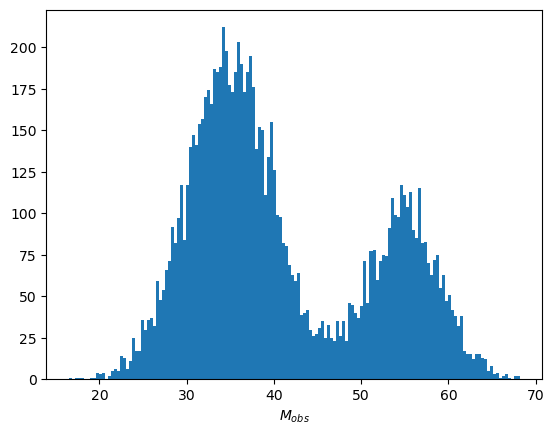

In [11]:
_ = plt.hist(mo, bins=150)
plt.xlabel(r'$M_{obs}$')

# With Selection

In [12]:
from scipy.interpolate import RectBivariateSpline, interp1d

In [13]:
with h5py.File('optimal_snr.h5', 'r') as inp:
    mass = np.array(inp['ms'])
    osnrs = np.array(inp['SNR'])
inp.close()

osnr_interp = RectBivariateSpline(mass, mass, osnrs)

def optimal_snr(m, z):
    m1z = m*(1.0+z)
    m2z = m*(1.0+z)
    dl = Planck18.luminosity_distance(z).to(unit.Gpc).value
    return osnr_interp.ev(m1z, m2z)/dl

def rho(optimal_snr, Theta):
    return optimal_snr*Theta

In [14]:
Theta = np.random.beta(2.0, 4.0, m.shape[0])

In [15]:
rhoo = rho(optimal_snr(m, z), Theta) + np.random.randn(m.shape[0])

In [16]:
mask = rhoo>8.0
rhoo_det = rhoo[mask]
Ndet = len(rhoo_det)
print(Ndet)

253


In [17]:
ms_det = ms[mask,:]
zs_det = zs[mask,:]

In [18]:
ms_det.shape, zs_det.shape

((253, 4000), (253, 4000))

In [19]:
with h5py.File("pe_samples_w_selection.h5", "w") as file:    
    file.create_dataset('ms_det', data=ms_det)
    file.create_dataset('zs_det', data=zs_det)
file.close()

In [20]:
ms_det.max(), ms_det.min()

(83.61963246401507, 10.282628095101634)

In [21]:
zs_det.max(), zs_det.min()

(2.324216998184627, 0.01224574688344266)